In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
torch.manual_seed(0)

# Define the Pareto front.
nadir = 0 * torch.ones(1, 2, **tkwargs)

pf = torch.tensor(
    [
        [0.3, 0.9],
        [0.5, 0.7],
        [0.6, 0.6],
        [0.7, 0.4],
        [0.95, 0.2],
    ],
    **tkwargs
)

# Polar parametrization.
num_weights = 201
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
s_fn = LengthScalarization(weights=weights, ref_points=nadir)
lengths = s_fn(pf).max(dim=0).values

points = torch.zeros(num_weights, 2, **tkwargs)
for i, w in enumerate(weights):
    points[i, :] = nadir + lengths[i] * w

# Smooth the Pareto front.
num_smooth = 100
stds = [0.05, 0.075, 0.1]
smoothed_lengths = torch.zeros(len(stds), num_smooth + 1, num_weights, **tkwargs)
smoothed_points = torch.zeros(len(stds), num_smooth + 1, num_weights, 2, **tkwargs)
mean_smoothed_points = torch.zeros(len(stds), num_weights, 2, **tkwargs)

for i, std in enumerate(stds):
    for j in range(num_smooth):
        Z = abs(std * torch.randn(2, **tkwargs))
        smoothed_lengths[i, j, ...] = s_fn(pf + Z).max(dim=0).values

    mean_length_i = smoothed_lengths.mean(dim=-2)[i]
    # Compute the mean
    for k, w in enumerate(weights):
        mean_smoothed_points[i, k, :] = nadir + mean_length_i[k] * w
        for j in range(num_smooth):
            smoothed_points[i, j, k, :] = nadir + smoothed_lengths[i, j, k] * w

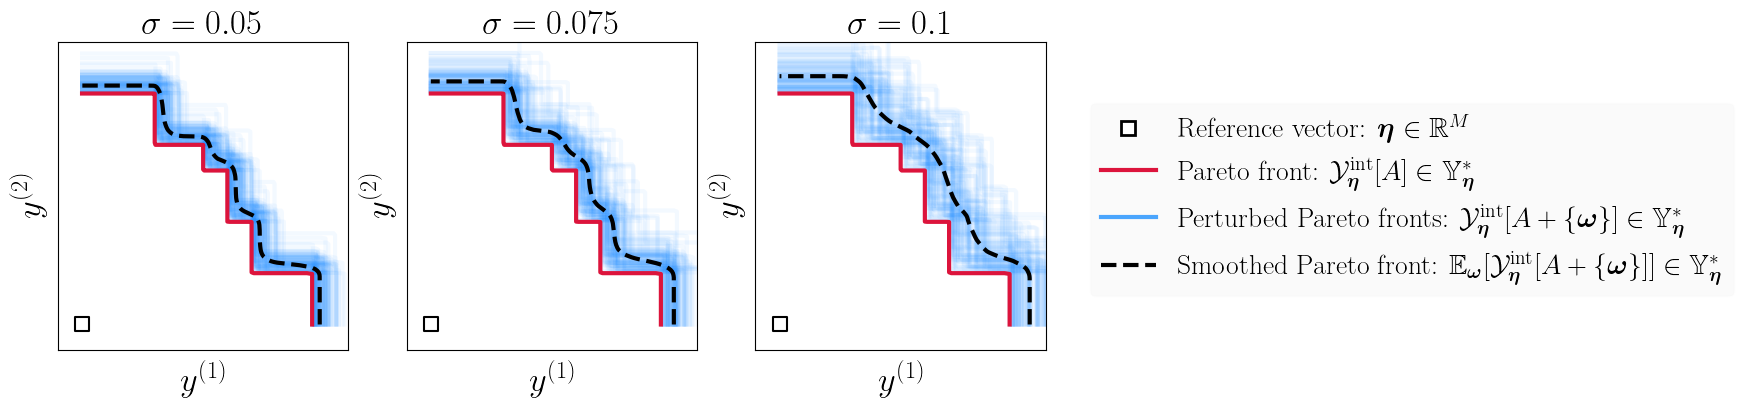

In [3]:
fig, axes = plt.subplots(1, len(stds), figsize=(4.25 * len(stds), 4))

for i in range(len(stds)):
    ax = plt.subplot(1, len(stds), i + 1)

    ax.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )

    ax.plot(
        points[:, 0],
        points[:, 1],
        color="crimson",
        linewidth=3,
        alpha=1,
        zorder=5,
    )

    ax.plot(
        mean_smoothed_points[i, :, 0],
        mean_smoothed_points[i, :, 1],
        color="k",
        linewidth=3,
        zorder=5,
        linestyle="--",
    )
    for j in range(num_smooth):
        ax.plot(
            smoothed_points[i, j, :, 0],
            smoothed_points[i, j, :, 1],
            color="dodgerblue",
            linewidth=3,
            alpha=0.05,
            zorder=1,
            linestyle="-",
        )

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$y^{(1)}$", fontsize=25)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=25)
    ax.set_title(rf"$\sigma={stds[i]}$", fontsize=25)
########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Pareto front: $\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[A] \in \mathbb{Y}_{\boldsymbol{\eta}}^*$",
)

blue_line = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    linestyle="-",
    linewidth=3,
    alpha=0.8,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Perturbed Pareto fronts: $\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[A + \{\boldsymbol{\omega}\}] \in \mathbb{Y}_{\boldsymbol{\eta}}^*$",
)

black_line = mlines.Line2D(
    [],
    [],
    color="k",
    linestyle="--",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Smoothed Pareto front: $\mathbb{E}_{\boldsymbol{\omega}}[\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[A+ \{\boldsymbol{\omega}\}]] \in \mathbb{Y}_{\boldsymbol{\eta}}^*$",
)

axes[2].legend(
    handles=[white_square, red_line, blue_line, black_line],
    ncol=1,
    fontsize=20,
    loc=(1.15, 0.175),
    facecolor="k",
    framealpha=0.02,
)

plt.show()